# 第6章 k平均法：教師なし学習モデルの基礎（自習書き込み用）

## 「06-k_means.py」の解説

ITエンジニアための機械学習理論入門「第6章 k平均法:教師なし学習モデルの基礎」で使用しているサンプルコード「06-k_means.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

特に、画像データを扱うためにPILモジュールを利用します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint
from PIL import Image

import matplotlib
matplotlib.rcParams['font.size'] = 12

画像ファイル「photo.jpg」をダウンドードします。

In [2]:
!curl -OL https://github.com/enakai00/jupyter_ml4se/raw/master/photo.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   139  100   139    0     0    574      0 --:--:-- --:--:-- --:--:--   574
100 47187  100 47187    0     0   164k      0 --:--:-- --:--:-- --:--:-- 1316k


画像ファイル「photo.jpg」を読み込みます。

In [3]:
im = Image.open("photo.jpg")    

画像を表示してみます。白、赤、緑の３色を中心に構成された画像です。

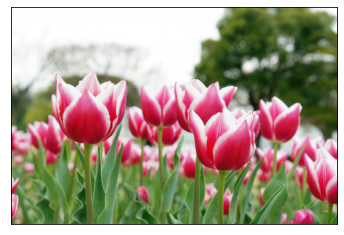

In [4]:
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(im)

画像データを各ピクセルの (R,G,B) を並べたリストに変換します。

In [5]:
pixels = list(im.convert('RGB').getdata())    

リストの先頭部分を確認すると、次のようになります。

In [6]:
pixels[:10]

[(251, 253, 252),
 (250, 252, 251),
 (250, 252, 251),
 (250, 252, 251),
 (251, 253, 252),
 (252, 254, 253),
 (253, 255, 254),
 (255, 255, 255),
 (254, 254, 254),
 (254, 254, 254)]

このリストから、k平均法で「代表色」を決定する関数を用意します。

k個の代表色を決定して、各ピクセルを代表色に置き換えたリストを返します。

In [7]:
def run_kmeans(pixels, k):
    #cls：どのピクセル（０番めから数えたピクセル）が、どの代表点（class)に属するかを保持
    #cls[100]=10の場合、99番目の画素は、k=10番目のグループ(class)に属する
    cls = [0] * len(pixels)

    # 代表色の初期値をランダムに設定
    center = [] #center = 代表点（代表色）＝μ
    for i in range(k):
        center.append(np.array([randint(256), randint(256), randint(256)]))
    print("Initial centers:", end='')
    print(list(map(lambda x: x.tolist(), center)))
    print("========================")
    distortion = 0.0

    # 最大50回のIterationを実施
    for iter_num in range(50): 
        center_new = []
        #center_new[k]：μkの分子の部分
        #num_points[k]：μkの分母の部分
        for i in range(k):
            center_new.append(np.array([0,0,0]))
        num_points = [0] * k
        distortion_new = 0.0 #distortionは歪みの意味

        # E Phase: 各データが属するグループ（代表色）を計算
        for pix, point in enumerate(pixels):
            #print("pix=", pix , " point=", point, " point class name=", point.__class__.__name__)
            #pix= 0  point= (251, 253, 252)  point class name= tuple
            #ここでpixは0番目からの通し番号、pointは画素データになる。
            min_dist = 256*256*3 #最小のargmin(k') |x-μk'|**2を求めるためのテンポラリ変数。初期値として最大のdist値を設定。途中の計算結果はこの値よりも必ず小さくなる
            
            #内側の和の計算　Σ(1<=k<=K) rnk|xn-μk|**2 を実行 #####
            #tuple型からnumpyの配列に変換する
            point = np.array(point)
            for i in range(k):
                d = sum([x*x for x in point-center[i]]) #ノルム２乗＝ベクトルの内積を計算する
                if d < min_dist: #argmin(k') |x-μk'|**2を計算している。計算するdの中で最も小さいdのclassを選択する。
                    min_dist = d
                    cls[pix] = i
            #################################################
            center_new[cls[pix]] += point #当該pixelが属するグループ(class)の画素（ベクトル）を加算
            num_points[cls[pix]] += 1     #当該pixelが属するグループ(class)の画素数を加算
            distortion_new += min_dist    #二乗歪み(J)を加算(内側の和の計算結果をΣしていく)

        # M Phase: 新しい代表色を計算
        for i in range(k):
            if num_points[i] == 0:
                center_new[i] = np.array([0,0,0])
            else:
                center_new[i] = center_new[i] / num_points[i]
        center = center_new
        print(list(map(lambda x: x.tolist(), center)))
        print("Distortion: J=%d" % distortion_new)

        # Distortion(J)の変化が0.1%未満になったら終了
        if iter_num > 0 and distortion - distortion_new < distortion * 0.001:
            break
        distortion = distortion_new
        
    # 画像データの各ピクセルを代表色で置き換え
    new_pixels = []
    for pix in range(len(pixels)):
        new_pixels.append(tuple(center[cls[pix]])) #各ピクセルが属するclassの画素になる。

    print("Done.")
    return list(map(lambda x: (int(x[0]), int(x[1]), int(x[2])), new_pixels))

例として、2つのクラスターに分類します。

In [8]:
result = run_kmeans(pixels, 2)

Initial centers:[[242, 63, 236], [101, 2, 101]]
[[231.474167829125, 207.74193424538322, 213.99466335632656], [105.69267348522808, 96.11413721617984, 58.98146019394582]]
Distortion: J=3722629366
[[233.3631284916201, 216.18749483997027, 220.73835209290806], [110.82216586166383, 96.07938757622662, 62.31078082166235]]
Distortion: J=918016168
[[234.31284765962266, 218.86664024571485, 223.0932612418791], [112.47681410098015, 96.57078402840696, 63.72126586680577]]
Distortion: J=900963884
[[234.6522683742603, 219.751536548412, 223.88293645121638], [113.02428199858127, 96.77406828061623, 64.21745575583405]]
Distortion: J=898952355
[[234.7686240768624, 220.0371549437155, 224.14169355416936], [113.2012161364977, 96.84665789354268, 64.38262921450288]]
Distortion: J=898724586
Done.


結果を画像として表示します。

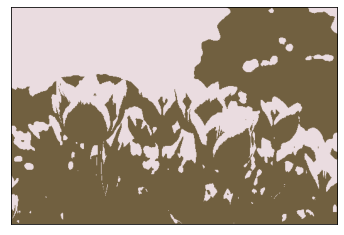

In [9]:
im.putdata(result)
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(im)

同様に3つのクラスターに分類します。

In [10]:
result = run_kmeans(pixels, 3)

Initial centers:[[226, 136, 249], [104, 29, 24], [175, 194, 136]]
[[243.0020763760317, 225.93563234301732, 232.97901129894623], [99.26266546169795, 79.37717293073202, 46.80282813247568], [156.38775249024167, 148.99187338694196, 122.39688159887379]]
Distortion: J=1605011869
[[239.97465546218487, 232.00003361344537, 234.65947899159664], [95.24771811207906, 83.9289169158757, 46.41783903263555], [166.41397379912664, 132.29981613422203, 119.33546311192829]]
Distortion: J=650087996
[[239.73239104034542, 232.54194778032655, 234.84538186479557], [90.37694658517141, 87.58340419877757, 45.83078660643104], [172.56552499338798, 124.23666578506568, 117.95342942784096]]
Distortion: J=615654768
[[239.5269240474388, 232.48017495163597, 234.69184960888217], [87.37463980807634, 90.88971090828676, 46.27908005307386], [176.32689372465222, 118.04984518773712, 116.00547294056081]]
Distortion: J=602628452
[[239.26037016602297, 232.16162578789854, 234.34824697798064], [85.32778114682299, 93.68429351121893, 46

結果を画像として表示します。

「白、赤、緑」が抽出されていることがわかります。

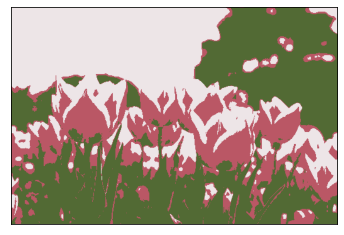

In [11]:
im.putdata(result)
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(im)

最後に、8つのクラスターに分類して、結果を画像として表示してみます。

In [12]:
result = run_kmeans(pixels, 8)

Initial centers:[[57, 51, 185], [115, 206, 25], [173, 167, 115], [103, 62, 83], [209, 77, 72], [138, 49, 242], [95, 107, 232], [198, 225, 253]]
[[0, 0, 0], [107.44528875379939, 140.26317122593719, 52.34422492401216], [160.12851692154976, 151.59351056239726, 126.3663492260446], [77.4913260344449, 93.6473005615334, 45.97495059133544], [199.8867157847734, 49.5128376869837, 84.93820049118106], [0, 0, 0], [0, 0, 0], [240.3633522036606, 234.35263779390823, 236.35807314277776]]
Distortion: J=790187154
[[23.23165841000236, 48.51073366359991, 15.075725406935598], [106.14650197756598, 133.61583349542892, 70.90848084030344], [173.86957736361097, 150.96336353114899, 138.56559045376542], [65.76313319567724, 88.5505081655091, 38.85237724920222], [192.30181952298992, 42.4271371199082, 75.78477174002131], [0, 0, 0], [0, 0, 0], [240.51682878540072, 233.58967031075147, 235.91615735559955]]
Distortion: J=335692003
[[32.08087887110522, 57.63320390188465, 18.949616440950848], [106.85094844112602, 132.74571

[[75.34103275957801, 105.03820099944475, 44.61354802887285], [136.70602524159054, 149.4883561282146, 107.16243333157311], [213.6927148869701, 157.2063175250575, 173.56011628411508], [102.05047514619883, 128.40972222222223, 67.75427631578947], [186.39520190863303, 35.97539100468322, 66.95869046567111], [51.34526461325755, 74.27098855518857, 28.771718257930715], [27.622549019607842, 53.61683006535948, 17.341230936819173], [243.93677500050435, 241.7106255926083, 242.49879965300894]]
Distortion: J=191865151
[[77.21602136181575, 106.96144192256342, 45.53356475300401], [138.34260184260185, 150.11954711954712, 108.81157731157731], [214.07085754226551, 157.38766327377573, 173.97907474553318], [103.46370067014148, 129.5469843633656, 69.51898734177215], [186.43315083009537, 36.004459554927585, 67.0085658777817], [52.54542739828294, 75.62150055991042, 29.71317655841732], [28.35021579080985, 54.364940340187864, 17.623889312008124], [243.96083223916776, 241.76495303504697, 242.54204625795373]]
Dist

[[90.33618256271617, 118.63984415377887, 54.90919572218026], [164.67876467160576, 149.47640056605343, 127.70082410721719], [218.35676982591878, 163.34530947775627, 181.53776595744682], [116.01720373766483, 140.31298576543534, 86.14465985503449], [186.58274461321088, 35.767220063581775, 67.06150653479335], [61.92724438092763, 88.44757697804339, 37.12933610497596], [35.24430017775717, 59.670067238581034, 20.13795501970786], [244.57782573509576, 242.79251312485735, 243.43323442136497]]
Distortion: J=184067540
[[90.79270899303357, 119.0002374920836, 55.34812381253958], [167.8690300344658, 147.1487772854095, 128.60044313146233], [218.41317189864765, 165.06869110970072, 182.740565346873], [116.56692085195898, 140.8045402752213, 86.87579980716978], [186.49181200905338, 35.5019305019305, 66.79754138374828], [62.34335952595646, 89.09925286615999, 37.396753832281334], [35.513718932887436, 59.85969445922323, 20.272250513034887], [244.702708902467, 242.9647571580506, 243.59645903280295]]
Distortio

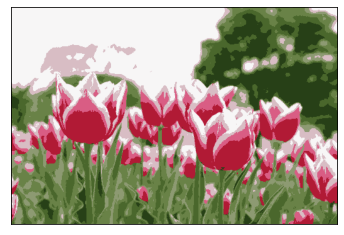

In [13]:
im.putdata(result)
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(im)

インターネットから好きな画像をダウンロードして試すこともできます。ここでは、無償利用可能なフリー素材をダウンロードしてみます。

In [14]:
!curl -OL http://2.bp.blogspot.com/-4SSFZUa0ab4/Vg57ivCMfhI/AAAAAAAAyzQ/Pm4eBFxAaOc/s800/sweets_fruit_pafe.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  310k  100  310k    0     0  8616k      0 --:--:-- --:--:-- --:--:-- 8616k


ダウンロードしたファイルを確認します。

In [15]:
!ls *.png

sweets_fruit_pafe.png


ファイルを読み込んで表示します。

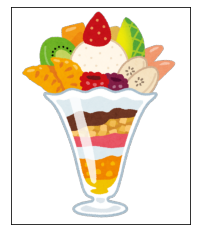

In [16]:
im = Image.open("sweets_fruit_pafe.png")
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(im)

RBG形式のデータに変換して、5つのクラスターに分類します。背景の透明色部分は、黒色に変換される点に注意してください。

In [17]:
pixels = list(im.convert('RGB').getdata())
result = run_kmeans(pixels, 5)

Initial centers:[[216, 157, 171], [88, 79, 75], [185, 26, 14], [5, 56, 72], [166, 41, 185]]
[[231.15147978507883, 215.77302621920785, 188.30232831263396], [111.29445921079534, 108.85970149253731, 45.42829687180536], [227.41356907894738, 111.3567228618421, 14.097800164473684], [0.00852670494769134, 0.016625501455203334, 0.015816880358687956], [147.8181818181818, 87.61363636363636, 135.29545454545453]]
Distortion: J=5083012536
[[232.86836748299925, 226.8331570292013, 215.0490510689364], [113.0148086057558, 114.06498223765617, 43.5757394324033], [229.04081022050684, 129.46545791820003, 24.845690093648088], [0.10148070618778661, 0.022768489968852054, 0.05705637747164154], [196.43490423929416, 96.18893910049495, 107.28814288788466]]
Distortion: J=1028671672
[[233.13100402700232, 231.73686360718247, 224.72916950372547], [111.26529777486911, 109.36677846858639, 44.43664103403141], [232.2890077925809, 156.3803102668151, 20.721926958020614], [0.12700273053199812, 0.02675858515080769, 0.07155941

結果を表示して確認します。

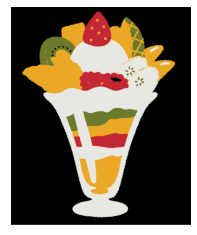

In [18]:
im.putdata(result)
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(im)